In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score


In [3]:
body = pd.read_csv(r"all_data/body_users.csv")

In [4]:
body.rename(columns={'Канал привлечения': 'acquisition_channel', 'sex_type': 'male'}, inplace=True)

In [5]:
body["male"] = body["male"].map({"М": 1, "Ж": 0})

In [6]:
segment = pd.read_csv(r"all_data\user_segment_slice.csv").sort_values('date')

In [7]:
# segsort_new = segsort[segsort['date']>='2025-07-01'] 
seg = segment[segment['date']<'2025-07-01']

In [8]:
merged_body_seg = seg.merge(
    body,
    left_on=["original_client_user_id", "user_id"],   # from seg
    right_on=["original_client_user_id", "id"],       # from body
    how="left"
)

In [10]:
# merged_body_seg.drop('id', axis=1,inplace=True)

In [9]:
evsort = pd.read_csv(r"all_data\user_events_slice.csv", index_col=False)

In [10]:
evsort.drop('Unnamed: 0', axis=1, inplace=True)

In [11]:
evsort["date"] = pd.to_datetime(evsort["date_mod"]).dt.floor('D')

In [12]:
evsort.drop('date_mod', axis=1, inplace=True)

In [14]:
merged_body_seg["date"] = pd.to_datetime(merged_body_seg["date"]).dt.floor('D')

In [51]:
evsort.user_id.nunique()

2221964

In [ ]:
merged2 = merged_body_seg.merge(
    evsort,
    on=["date", "user_id"],  
    # ["date", "user_id"], 
    how=""
)

In [18]:
merged2.male.isnull().sum()

39633106

In [19]:
merged2 = merged2.dropna(subset='name')

In [22]:
merged2 = merged2.dropna(subset='male')

In [26]:
merged2.drop('id', axis=1, inplace=True)

In [37]:
# Step 1. Build account-level activity
activity = (
    merged2.groupby("user_id")
      .agg(
          n_events=("name", "count"),
          n_unique_events=("name", "nunique"),
          n_days=("date", "nunique"),
          first_event=("date", "min"),
          last_event=("date", "max")
      )
      .reset_index()
)

activity["active_period"] = (
    pd.to_datetime(activity["last_event"]) - 
    pd.to_datetime(activity["first_event"])
).dt.days

# Step 2. Add demographics & channels
user_info = (
    merged2.groupby("user_id")
      .agg({
          "male": "first",
          "age_segment": lambda x: x.mode().iat[0] if not x.mode().empty else "Unknown",
          "acquisition_channel": lambda x: x.mode().iat[0] if not x.mode().empty else "Unknown",
          "acquisition_channel_lvl_2": lambda x: x.mode().iat[0] if not x.mode().empty else "Unknown",
          "acquisition_channel_lvl_3": lambda x: x.mode().iat[0] if not x.mode().empty else "Unknown",
          "user_segment_in_reception_id": lambda x: x.mode().iat[0] if not x.mode().empty else -1,
          "original_client_user_id": "first"
      })
      .reset_index()
)

accounts = activity.merge(user_info, on="user_id", how="left")

# Step 3. Aggregate to client level (original_client_user_id)
clients = (
    accounts.groupby("original_client_user_id")
    .agg(
        n_accounts=("user_id", "nunique"),
        total_events=("n_events", "sum"),
        avg_events_per_acc=("n_events", "mean"),
        total_days_active=("n_days", "sum"),
        male=("male", "first"),  # could also use mode
        age_segment=("age_segment", lambda x: x.mode().iat[0] if not x.mode().empty else "Unknown"),
        acquisition_channel=("acquisition_channel", lambda x: x.mode().iat[0] if not x.mode().empty else "Unknown"),
        acquisition_channel_lvl_2=("acquisition_channel_lvl_2", lambda x: x.mode().iat[0] if not x.mode().empty else "Unknown"),
        acquisition_channel_lvl_3=("acquisition_channel_lvl_3", lambda x: x.mode().iat[0] if not x.mode().empty else "Unknown"),
        user_segment_in_reception_id=("user_segment_in_reception_id", lambda x: x.mode().iat[0] if not x.mode().empty else -1)
    )
    .reset_index()
)

In [ ]:
# Numeric features
num_features = ["n_accounts", "total_events", "avg_events_per_acc", "total_days_active"]
X_num = clients[num_features]

# Categorical features (one-hot encode)
cat_features = ["age_segment", "acquisition_channel_lvl_2", "acquisition_channel_lvl_3", "user_segment_in_reception_id"]
X_cat = pd.get_dummies(clients[cat_features], drop_first=True)

# Combine
X_full = pd.concat([X_num, X_cat], axis=1)

# Scale numerics
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full)

    k  silhouette  calinski_harabasz  davies_bouldin
0   2    0.089827        3089.862111        2.264869
1   3    0.175149        2799.472024        2.303737
2   4    0.176258        2614.490842        1.657337
3   5    0.202149        2324.270115        1.970806
4   6    0.235265        2289.537936        2.437556
5   7    0.259901        2356.199672        1.523116
6   8    0.264902        2405.629296        1.630041
7   9    0.257271        2273.472227        1.452441
8  10    0.245441        2149.370822        1.170733


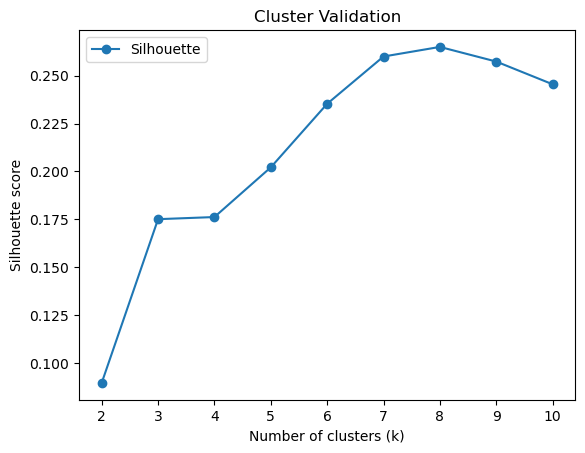

In [ ]:
scores = []
range_k = range(2, 8)  # test clusters from 2 to 10

for k in range_k:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)

    sil = silhouette_score(X_scaled, labels)
    ch = calinski_harabasz_score(X_scaled, labels)
    db = davies_bouldin_score(X_scaled, labels)

    scores.append((k, sil, ch, db))

# Convert to DataFrame for easy plotting
import pandas as pd
cv_results = pd.DataFrame(scores, columns=["k", "silhouette", "calinski_harabasz", "davies_bouldin"])
print(cv_results)

# Plot silhouette score
plt.plot(cv_results["k"], cv_results["silhouette"], marker="o", label="Silhouette")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.title("Cluster Validation")
plt.legend()
plt.show()


In [ ]:
def clustering_stability(X, k, n_runs=5):
    labels_runs = []
    for i in range(n_runs):
        km = KMeans(n_clusters=k, random_state=i, n_init=10)
        labels_runs.append(km.fit_predict(X))
    # Compare consistency across runs
    from sklearn.metrics import adjusted_rand_score
    scores = [adjusted_rand_score(labels_runs[0], labels_runs[i]) for i in range(1, n_runs)]
    return np.mean(scores)

print("Stability for k=4:", clustering_stability(X_scaled, k=4))

In [54]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)

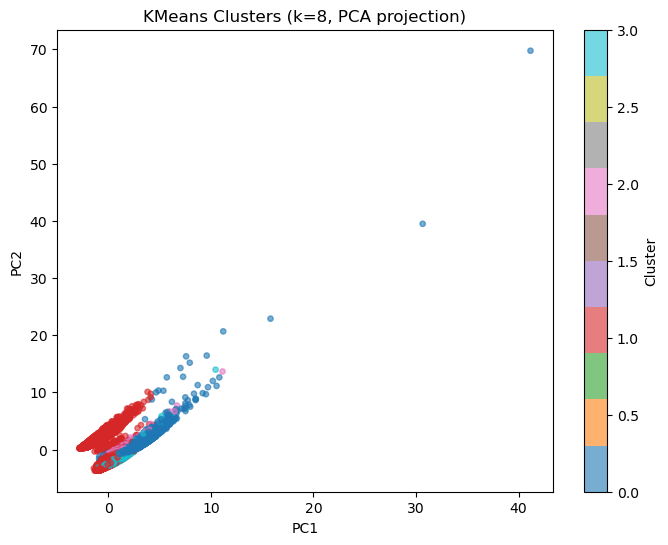

In [55]:
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(
    coords[:,0], coords[:,1],
    c=labels, cmap="tab10", alpha=0.6, s=15
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("KMeans Clusters (k=8, PCA projection)")
plt.colorbar(label="Cluster")
plt.show()

In [46]:
merge_ar = pd.read_csv(r"merged_data_ar\merged_data_ar.csv")

C:\Users\g1kss\AppData\Local\Temp\ipykernel_13632\4011470357.py:1: DtypeWarning: Columns (6,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  merge_ar = pd.read_csv(r"merged_data_ar\merged_data_ar.csv")


In [69]:
onboarding_pass =['Account successfully created for user', 'Account setup completed successfully', 
 'Initiated account registration', 'Account set up through a mobile device', 'User session established', 
 'User profile status changed', 'Chosen a pricing plan for the accoun', 'Unable to create account', 'Account opened successfully', 
 'Switched to live environment', 'Account registered under a personal name', 'Account created for a business or organization'
 ]

onboarding_df = merged2[merged2['name'].isin(onboarding_pass)]

In [31]:
# Step 1. Build account-level activity
activity = (
    merge2.groupby("user_id")
      .agg(
          n_events=("name", "count"),
          n_unique_events=("name", "nunique"),
          n_days=("date", "nunique"),
          first_event=("date", "min"),
          last_event=("date", "max")
      )
      .reset_index()
)

activity["active_period"] = (
    pd.to_datetime(activity["last_event"]) - 
    pd.to_datetime(activity["first_event"])
).dt.days

# Step 2. Add demographics & channels
user_info = (
    merge2.groupby("user_id")
      .agg({
          "male": "first",
          "age_segment": lambda x: x.mode().iat[0] if not x.mode().empty else "Unknown",
          "acquisition_channel": lambda x: x.mode().iat[0] if not x.mode().empty else "Unknown",
          "acquisition_channel_lvl_2": lambda x: x.mode().iat[0] if not x.mode().empty else "Unknown",
          "acquisition_channel_lvl_3": lambda x: x.mode().iat[0] if not x.mode().empty else "Unknown",
          "user_segment_in_reception_id": lambda x: x.mode().iat[0] if not x.mode().empty else -1,
          "original_client_user_id": "first"
      })
      .reset_index()
)

accounts = activity.merge(user_info, on="user_id", how="left")

clients = (
    accounts.groupby("original_client_user_id")
    .agg(
        n_accounts=("user_id", "nunique"),
        total_events=("n_events", "sum"),
        avg_events_per_acc=("n_events", "mean"),
        total_days_active=("n_days", "sum"),
        male=("male", "first"),  # could also use mode
        age_segment=("age_segment", lambda x: x.mode().iat[0] if not x.mode().empty else "Unknown"),
        acquisition_channel=("acquisition_channel", lambda x: x.mode().iat[0] if not x.mode().empty else "Unknown"),
        acquisition_channel_lvl_2=("acquisition_channel_lvl_2", lambda x: x.mode().iat[0] if not x.mode().empty else "Unknown"),
        acquisition_channel_lvl_3=("acquisition_channel_lvl_3", lambda x: x.mode().iat[0] if not x.mode().empty else "Unknown"),
        user_segment_in_reception_id=("user_segment_in_reception_id", lambda x: x.mode().iat[0] if not x.mode().empty else -1),
        first_date=("first_event", "min"),
        last_date=("last_event", "max")
    )
    .reset_index()
)

In [36]:
clients_ordered = clients.sort_values(by='first_date', ascending=False)

In [29]:
merge2 = pd.read_csv('mini_merge.csv')

In [39]:
new_clients = clients_ordered[clients_ordered['first_date'] >= '2025-06-01']
old_clients = clients_ordered[clients_ordered['first_date'] < '2025-06-01']

In [ ]:
# new_clients.to_csv('new_clients.csv')
# old_clients.to_csv('old_clients.csv')

In [ ]:
# clients.to_csv('aggregated_users_onboarding.csv')

In [ ]:
clusters = pd.read_csv(r"old_clients_with_clusters1.csv")

In [12]:
columns = []
for i in clusters[clusters['cluster_k7']==0].columns:
    columns.append(i)
print(columns)

['original_client_user_id', 'n_accounts', 'total_events', 'avg_events_per_acc', 'total_days_active', 'acquisition_channel', 'acquisition_channel_lvl_2', 'acquisition_channel_lvl_3', 'user_segment_in_reception_id', 'first_date', 'last_date', 'Security-related session initiated_frequency', 'Security-related session initiated_eng_weighted', 'Security-related session initiated_avg_engagement', 'Security-related session initiated_eng_volatility', 'Trading activity over 30 days_frequency', 'Trading activity over 30 days_eng_weighted', 'Trading activity over 30 days_avg_engagement', 'Trading activity over 30 days_eng_volatility', 'User logged in_frequency', 'User logged in_eng_weighted', 'User logged in_avg_engagement', 'User logged in_eng_volatility', 'Authentication completed_frequency', 'Authentication completed_eng_weighted', 'Authentication completed_avg_engagement', 'Authentication completed_eng_volatility', 'Card used to top up account_frequency', 'Card used to top up account_eng_weigh

In [ ]:
clusters_new = clusters_new.drop(
    columns=[col for col in clusters_new.columns if "eng" in col or "vol" in col]
)

In [56]:
clusters_new['cluster_k7'] = clusters['cluster_k7']

In [50]:
clusters_new.drop('cluster_k7', axis=1, inplace=True)

In [51]:
clusters_new.to_csv('clusters_new_data.csv')

In [45]:
clusters_new = clusters.merge(old_clients, on='original_client_user_id', how='left')

In [66]:
clusters = sorted(clusters_new["cluster_k7"].unique())

for i in clusters:
    subset = clusters_new[clusters_new["cluster_k7"] == i]

    print("="*40)
    print(f"[Cluster {i}]")
    print("="*40)

    # categorical (most frequent)
    print(f"Most popular age: {subset['age_segment'].mode().iloc[0]}")
    print(f"Most popular sex_type: {subset['male'].mode().iloc[0]}")
    print(f"Most used acquisition_channel 1: {subset['acquisition_channel_x'].mode().iloc[0]}")
    print(f"Most used acquisition_channel 2: {subset['acquisition_channel_lvl_2_x'].mode().iloc[0]}")
    print(f"Most used acquisition_channel 3: {subset['acquisition_channel_lvl_3_x'].mode().iloc[0]}")

    # numerical (averages)
    print(f"Average n_acc: {subset['n_accounts_x'].mean():.1f}")
    print(f"Average total_events: {subset['total_events_x'].mean():.1f}")
    print(f"Average avg_events_per_acc: {subset['avg_events_per_acc_x'].mean():.1f}")
    print(f"Average total_days_active: {subset['total_days_active_x'].mean():.1f}")
    print()


[Cluster 0]
Most popular age: 35-44 лет
Most popular sex_type: 1.0
Most used acquisition_channel 1: Рефералка Sales
Most used acquisition_channel 2: Рефералка Sales
Most used acquisition_channel 3: Рефералка Sales
Average n_acc: 1.6
Average total_events: 49.7
Average avg_events_per_acc: 31.2
Average total_days_active: 7.1

[Cluster 1]
Most popular age: 35-44 лет
Most popular sex_type: 1.0
Most used acquisition_channel 1: Органика
Most used acquisition_channel 2: Органика
Most used acquisition_channel 3: Органика
Average n_acc: 1.5
Average total_events: 24.6
Average avg_events_per_acc: 16.5
Average total_days_active: 7.4

[Cluster 2]
Most popular age: 35-44 лет
Most popular sex_type: 1.0
Most used acquisition_channel 1: Органика
Most used acquisition_channel 2: Органика
Most used acquisition_channel 3: Органика
Average n_acc: 1.3
Average total_events: 6.7
Average avg_events_per_acc: 5.5
Average total_days_active: 2.5

[Cluster 3]
Most popular age: 25-34 лет
Most popular sex_type: 1.0
Mo

In [7]:
clusters.drop('Unnamed: 0', axis=1,inplace=True)

In [67]:
onboard = pd.read_csv(r"onboarding_mess.csv")

In [69]:
onboard.drop('Unnamed: 0',axis=1,inplace=True)

In [79]:
steps = [
        'Account successfully created for user',
       'Account setup completed successfully',
       'Initiated account registration',
       'Account set up through a mobile device', 'User session established',
       'User profile status changed', 'Chosen a pricing plan for the accoun',
       'Unable to create account', 'Account opened successfully',
       'Switched to live environment',
       'Account registered under a personal name']

In [82]:
for i in steps:
    if i in onboard.columns:
        print(i)

Account successfully created for user
Account setup completed successfully
Initiated account registration
Account set up through a mobile device
User session established
User profile status changed
Chosen a pricing plan for the accoun
Unable to create account
Account opened successfully
Switched to live environment
Account registered under a personal name


In [94]:
# Пример бизнес-правил для условного делителя
denominators = {
    "Account successfully created for user": "self",   # 100%
    "Account setup completed successfully": "Account successfully created for user",
    "Initiated account registration": "Account successfully created for user",
    "Account set up through a mobile device": "Account successfully created for user",
    "User session established": ["Account set up through a mobile device", "extra2500"],
    "User profile status changed": ["User session established", "extra500"],
    "Chosen a pricing plan for the accoun": "User profile status changed",
    "Unable to create account": "User session established",
    "Account opened successfully": "Account opened successfully",  # база = сама
    "Switched to live environment": "Account opened successfully",
    "Account registered under a personal name": "Account opened successfully"
}

funnel_df["conditional_rate_%"] = None

for i, row in funnel_df.iterrows():
    step = row["step"]
    num = row["users_completed"]

    denom_rule = denominators.get(step, "self")

    if denom_rule == "self":
        denom = num
    elif isinstance(denom_rule, str):
        denom = funnel_df.loc[funnel_df["step"] == denom_rule, "users_completed"].values[0]
    elif isinstance(denom_rule, list):
        denom = 0
        for dr in denom_rule:
            if isinstance(dr, str) and dr.startswith("extra"):
                denom += int(dr.replace("extra", ""))  # добавляем кастомное число
            else:
                denom += funnel_df.loc[funnel_df["step"] == dr, "users_completed"].values[0]
    else:
        denom = num

    funnel_df.loc[i, "conditional_rate_%"] = round(num / denom * 100, 2) if denom > 0 else None

print(funnel_df)


                                                                              step  \
Account successfully created for user        Account successfully created for user   
Account setup completed successfully          Account setup completed successfully   
Initiated account registration                      Initiated account registration   
Account set up through a mobile device      Account set up through a mobile device   
User session established                                  User session established   
User profile status changed                            User profile status changed   
Chosen a pricing plan for the accoun          Chosen a pricing plan for the accoun   
Unable to create account                                  Unable to create account   
Account opened successfully                            Account opened successfully   
Switched to live environment                          Switched to live environment   
Account registered under a personal name  Account regi

In [92]:
unique_onboard.original_client_user_id.nunique()

90045

In [96]:
vals = {
    "Account successfully created for user": 1811,
    "Account setup completed successfully": 1811,
    "Initiated account registration": 1723,
    "Account set up through a mobile device": 3947,
    "User session established": 4516,
    "User profile status changed": 4581,
    "Chosen a pricing plan for the accoun": 5446,
    "Unable to create account": 744,
    "Account opened successfully": 5546,
    "Switched to live environment": 5546,
    "Account registered under a personal name": 93
}

calc = {
    "Account successfully created for user": 100.0,  # база
    "Account setup completed successfully": vals["Account setup completed successfully"] / vals["Account successfully created for user"] * 100,
    "Initiated account registration": vals["Initiated account registration"] / vals["Account successfully created for user"] * 100,
    # "Account set up through a mobile device": vals["Account set up through a mobile device"] / vals["Account successfully created for user"] * 100,
    "User session established": vals["User session established"] / (vals["Account set up through a mobile device"] + 2500) * 100,
    "User profile status changed": vals["User profile status changed"] / 5000 * 100,
    # "Chosen a pricing plan for the accoun": vals["Chosen a pricing plan for the accoun"] / vals["User profile status changed"] * 100,
    "Unable to create account": vals["Unable to create account"] / 3000 * 100,
    "Account opened successfully": vals["Account opened successfully"] / vals["Account opened successfully"] * 100,
    "Switched to live environment": vals["Switched to live environment"] / vals["Account opened successfully"] * 100,
    "Account registered under a personal name": vals["Account registered under a personal name"] / vals["Account opened successfully"] * 100
}

funnel_custom = pd.DataFrame([
    {"step": step, "users_completed": vals[step], "conversion_%": round(conv, 2)}
    for step, conv in calc.items()
])

print(funnel_custom)

                                       step  users_completed  conversion_%
0     Account successfully created for user             1811        100.00
1      Account setup completed successfully             1811        100.00
2            Initiated account registration             1723         95.14
3                  User session established             4516         70.05
4               User profile status changed             4581         91.62
5                  Unable to create account              744         24.80
6               Account opened successfully             5546        100.00
7              Switched to live environment             5546        100.00
8  Account registered under a personal name               93          1.68
